In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = './augmented/'

In [2]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    u = file.split('_')
    rawy.append(u[2])

In [3]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [4]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h*im_w)
print(x.shape)
print(y.shape)

(5400, 2500)
(5400,)


In [5]:
rawx= None
rawy= None

In [6]:
x = x / 255.

In [7]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5'], dtype='<U1')

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [9]:
x = None
y = None

In [10]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

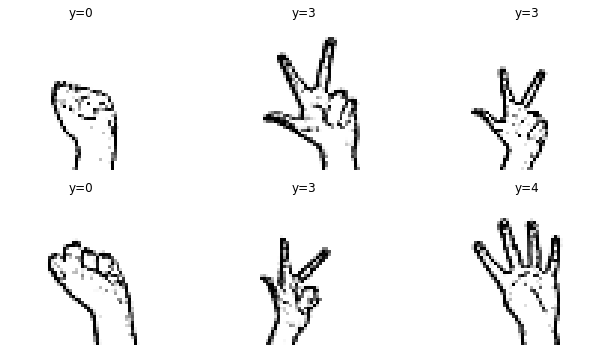

In [11]:
plot_6_images(xtrain,ytrain)

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
%time X_reduced = pca.fit_transform(xtrain)

Wall time: 7.22 s


In [13]:
print('dimension reduction from %d to %d after PCA preserving 95%% of variance' % (xtrain.shape[1],pca.n_components_))

dimension reduction from 2500 to 688 after PCA preserving 95% of variance


check how pictures looks like after PCA

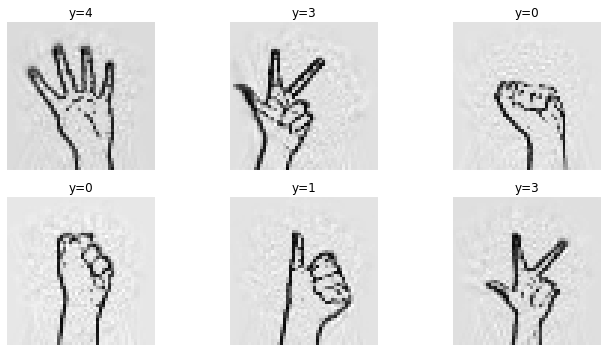

In [14]:
images = pca.inverse_transform(X_reduced)
plot_6_images(images,ytrain)

In [15]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
ytrain_enc = encoder.fit_transform(ytrain)
print("ytrain: ",ytrain[:10])
print("ytrain_enc: ",ytrain_enc[:10])

ytest_enc = encoder.fit_transform(ytest)

ytrain:  ['3' '2' '5' '2' '0' '1' '0' '0' '5' '3']
ytrain_enc:  [3 2 5 2 0 1 0 0 5 3]


Try different classifiers with default parameters

In [16]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

classifs = [
           SGDClassifier(random_state=37), 
           KNeighborsClassifier(),
           DecisionTreeClassifier(),
           SVC(),
           RandomForestClassifier(random_state=37),
           AdaBoostClassifier(random_state=37),
           ]

classif_names=[
               'SGD\t\t',
               'KNN\t\t', 
               'DecisionTree\t', 
               'SVC\t\t',
               'RandomForest\t',
               'AdaBoost\t\t',
               ]

# Apply different classifiers

for name, clf in zip(classif_names, classifs):
    %time score = cross_val_score(clf, xtrain, ytrain_enc, cv=3, scoring="accuracy")
    print("%s : %s Score :" % (name,score), " Worst: %.4f" % score.min())


Wall time: 3.52 s
SGD		 : [0.95833333 0.93194444 0.92916667] Score :  Worst: 0.9292
Wall time: 46.7 s
KNN		 : [0.92638889 0.925      0.91597222] Score :  Worst: 0.9160
Wall time: 3.26 s
DecisionTree	 : [0.79444444 0.79722222 0.79722222] Score :  Worst: 0.7944
Wall time: 1min 38s
SVC		 : [0.99444444 0.9875     0.98680556] Score :  Worst: 0.9868
Wall time: 6.37 s
RandomForest	 : [0.97847222 0.98194444 0.96805556] Score :  Worst: 0.9681
Wall time: 32.9 s
AdaBoost		 : [0.57986111 0.51180556 0.57777778] Score :  Worst: 0.5118


SGDClassifier (using linear SVM) and Random Frorest give good results in quite small time.
Try to fine tune those two models to improve performance.

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'penalty':['l2','elasticnet'],
        'alpha':[10 ** x for x in range(-5, -3)],
        'learning_rate':['optimal','adaptive'],
        'eta0':[0.1,0.01]
    }
]

clf = SGDClassifier(random_state=37)
grid_search = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search.fit(xtrain,ytrain_enc);

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.6min finished


Wall time: 3min 49s


GridSearchCV(cv=3, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=37,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': [1e-05, 0.0001], 'eta0': [0.1, 0.01],
                          'learning_rate': ['optimal', 'adaptive'],
                          'penalty': ['l2', 'elasticnet']}],
         

In [18]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'alpha': 1e-05, 'eta0': 0.01, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}
0.9664351851851851


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'bootstrap':[True,False],
        'n_estimators':[10,50,100,],
        'max_features':[5,10,'auto'],
        'max_depth':[5,10,None],
    }
]

clf = RandomForestClassifier(random_state=37)
grid_search_rf = GridSearchCV(clf,param_grid,cv=3,return_train_score=True,verbose=1)
%time grid_search_rf.fit(xtrain,ytrain_enc);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  1.8min finished


Wall time: 1min 55s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=37,
                                  

In [20]:
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

{'bootstrap': False, 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
0.982638888888889


Check RESULTS on test set: confusion matrix from predicted values using SGD

In [21]:
from sklearn.model_selection import cross_val_predict

ytest_pred = cross_val_predict(grid_search.best_estimator_,xtest,ytest_enc,cv=3)
score = grid_search.best_estimator_.score(xtest, ytest_enc)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 98.15% on test dataset (1080 obs)


In [22]:
import pandas as pd

pd.crosstab(encoder.inverse_transform(ytest_enc), encoder.inverse_transform(ytest_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,164,12,0,3,0,1,180
1,12,159,7,1,1,0,180
2,6,14,147,7,6,0,180
3,7,6,10,144,4,9,180
4,4,2,3,1,169,1,180
5,1,0,2,8,9,160,180
All,194,193,169,164,189,171,1080


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(ytest_enc, ytest_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       180
           1       0.82      0.88      0.85       180
           2       0.87      0.82      0.84       180
           3       0.88      0.80      0.84       180
           4       0.89      0.94      0.92       180
           5       0.94      0.89      0.91       180

    accuracy                           0.87      1080
   macro avg       0.87      0.87      0.87      1080
weighted avg       0.87      0.87      0.87      1080



Check confusion matrix from predicted values using RF

In [24]:
from sklearn.model_selection import cross_val_predict

ytest_pred = cross_val_predict(grid_search_rf.best_estimator_,xtest,ytest_enc,cv=3)
score = grid_search_rf.best_estimator_.score(xtest, ytest_enc)*100

print("Model score: %.2f%% on test dataset (%d obs)" % (score,len(ytest)))

Model score: 99.26% on test dataset (1080 obs)


In [25]:
import pandas as pd

pd.crosstab(encoder.inverse_transform(ytest_enc), encoder.inverse_transform(ytest_pred), rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,172,5,1,0,0,2,180
1,7,168,4,1,0,0,180
2,9,6,161,3,1,0,180
3,3,1,13,159,2,2,180
4,8,0,0,0,161,11,180
5,0,0,0,6,6,168,180
All,199,180,179,169,170,183,1080


In [26]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(ytest_enc, ytest_pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       180
           1       0.93      0.93      0.93       180
           2       0.90      0.89      0.90       180
           3       0.94      0.88      0.91       180
           4       0.95      0.89      0.92       180
           5       0.92      0.93      0.93       180

    accuracy                           0.92      1080
   macro avg       0.92      0.92      0.92      1080
weighted avg       0.92      0.92      0.92      1080



Save RF Model

In [ ]:
import pickle

filename = 'model_classic.sav'
pickle.dump(grid_search_rf.best_estimator_, open(filename, 'wb'))

Check if model works on 1 image

In [27]:
import pickle
filename = 'model_classic.sav'
loaded_model = pickle.load(open(filename, 'rb'))

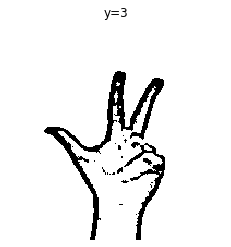

In [32]:
files = os.listdir('./originals/')
idx = random.randint(0,len(files))
origimg = cv2.imread('./originals/'+files[idx],cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h* im_w)

result = loaded_model.predict(myimg)
pred = result[0]

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');